In [1]:
# Using data from the Fresno Aeronet site
####################################################################################################

# must insert this statement to render the plots within the notebook
# this is specific to the ipython notebook
%matplotlib inline

## Import statements
# netcdf/numpy/xray/stats
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
import xarray as xray
import kray
from scipy.stats.stats import pearsonr

# OS interaction
import sys, pickle, os

# import subplots function for plotting
import seaborn as sns
sns.set_style("whitegrid")
import matplotlib
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap

# Solargeometry
import solargeo

## Directory listing
dir_data = '/Users/karllapo/gdrive/SnowHydrology/proj/CloudClimatology/data'
dir_print = '/Users/karllapo/gdrive/SnowHydrology/proj/CloudClimatology/Graphics'
# Directory for basemap pickle files
dir_bmap = '/Users/karllapo/gdrive/SnowHydrology/proj/CloudClimatology/data/basemap'

In [2]:
####################################################################################################
# Load Data
####################################################################################################
os.chdir(dir_data)
grobs = xray.open_dataset('grobs.daily.nc')
grobs_diff = xray.open_dataset('grobs_bias.daily.nc')
anom_day = xray.open_dataset('tau_anom.daily.nc')
anom_mon = xray.open_dataset('tau_anom.monthly.nc')
tau = xray.open_dataset('tau.daily.nc')
tau = tau.tau

## Names
pr_names = ['mtclim','nldas','syn','wrf']
num_products = np.size(pr_names)
grouping = ['north cv','south cv','west of crest','foothills','east of crest']
pr_for_plot = ['grobs','mtclim','nldas','syn','wrf']

## Transmissivity
tau_products = xray.Dataset()
pr_names_plot = ['mtclim','nldas','syn','wrf','grobs']
for pr in pr_names_plot:
    tau_products[pr] = grobs[pr]/(np.sin(grobs.el*np.pi/180)*1365)
    
## Transmissivity anomalies
anom_day = xray.open_dataset('tau_anom.daily.nc')
anom_mon = xray.open_dataset('tau_anom.monthly.nc')

In [3]:
####################################################################################################
# Aerosol Correlations
####################################################################################################

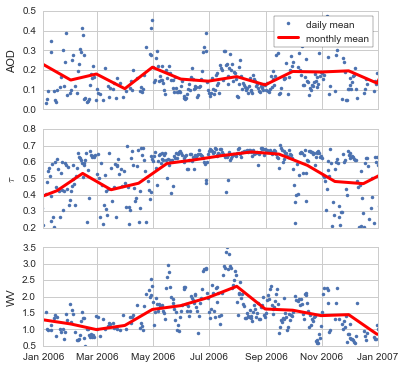

In [4]:
#### Time series
## AOD
f,axes = plt.subplots(3,1,sharex=True,figsize=(6,6))
axes[0].plot(grobs.time,grobs.aod.values,'.',label='daily mean')
axes[0].plot(grobs.aod.resample(freq='M',dim='time',how='mean').time,\
         grobs.aod.resample(freq='M',dim='time',how='mean').values,'r',linewidth=3,label='monthly mean')
axes[0].set_xlim([datetime(2006,1,1),datetime(2007,1,1)])
axes[0].set_ylabel('AOD')
axes[0].set_ylim([0.,.5])
leg = axes[0].legend(frameon=True)
leg.get_frame().set_edgecolor('k')

## Transmissivity
axes[1].plot(tau.time,tau.loc[{'station':'FRESNO'}].values,'.')
axes[1].plot(tau.loc[{'station':'FRESNO'}].resample(freq='M',dim='time',how='mean').time-pd.Timedelta(days=15),\
            tau.loc[{'station':'FRESNO'}].resample(freq='M',dim='time',how='mean').values,\
            'r',linewidth=3)
axes[1].set_xlim([datetime(2006,1,1),datetime(2007,1,1)])
axes[1].set_ylabel('$\\tau$')
axes[1].set_ylim([.2,.8])

## WV
axes[2].plot(grobs.time,grobs.wv.values,'.')
axes[2].plot(grobs.wv.resample(freq='M',dim='time',how='mean').time,\
         grobs.wv.resample(freq='M',dim='time',how='mean').values,'r',linewidth=3)
axes[2].set_xlim([datetime(2006,1,1),datetime(2007,1,1)])
axes[2].set_ylabel('WV')
axes[2].set_ylim([.5,3.5])

# Output
os.chdir(dir_print)
fname = 'Tau_AOD_WV.TimeSeries.png'
f.savefig(fname)

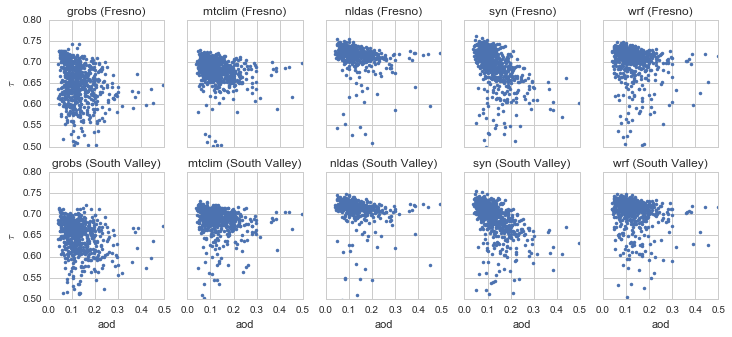

In [5]:
#### Correlations - AOD
# AOD
a = grobs.aod.values

## Correlation with transmissivity w/ products
f, axes = plt.subplots(2, num_products+1, figsize=(12,5),sharex='col',sharey='row')
for n,pr in enumerate(pr_for_plot):
    tau_pr = grobs[pr].where(np.logical_and(grobs['time.month'] > 5 ,grobs['time.month'] < 10))/ \
        (np.sin(grobs.el.where(np.logical_and(grobs['time.month'] > 5 ,grobs['time.month'] < 10))*np.pi/180)*1365)
    
    # @ Fresno
    ax = axes[0,n]
    ax.plot(a,tau_pr.loc[{'station':'FRESNO'}].values,'.')
    ax.set_title(pr+' (Fresno)')
    ax.set_ylim(.5, .8)
    if pr == 'SWdwn':
        ax.set_title('Ground Obs. (Fresno)')
    if n == 0:
        ax.set_ylabel('$\\tau$')
    
    tau_pr = kray.group_mean(tau_pr.swap_dims({'station':'Grouping'}),'Grouping',grouping)
    tau_pr = kray.combinevars(tau_pr,grouping,new_dim_name='Grouping',combinevarname='tau')

    # over group
    ax = axes[1,n]
    ax.plot(a,tau_pr.loc[{'Grouping':'south cv'}].values,'.')
    ax.set_ylim([.5,.8])
    ax.set_xlim([0,.5])
    ax.set_xlabel('aod')
    if n == 0:
        ax.set_ylabel('$\\tau$')
    ax.set_title(pr+ ' (South Valley)')
    if pr == 'SWdwn':
        ax.set_title('Ground Obs. (South Valley)')

# Output
os.chdir(dir_print)
fname = 'Tau_AOD.SCV_Fresno.Scatter.png'
f.savefig(fname)

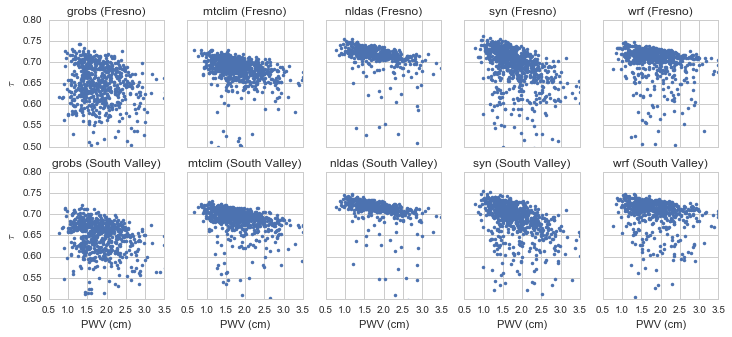

In [6]:
#### Correlations - PWV
# PWV
wv = grobs.wv.values
    
## Correlation with transmissivity w/ products
f, axes = plt.subplots(2, num_products+1, figsize=(12,5),sharex='col',sharey='row')
for n,pr in enumerate(pr_for_plot):
    tau_pr = grobs[pr].where(np.logical_and(grobs['time.month'] > 5 ,grobs['time.month'] < 10))/ \
        (np.sin(grobs.el.where(np.logical_and(grobs['time.month'] > 5 ,grobs['time.month'] < 10))*np.pi/180)*1365)
    
    # @ Fresno
    ax = axes[0,n]
    ax.plot(wv,tau_pr.loc[{'station':'FRESNO'}].values,'.')
    ax.set_title(pr+' (Fresno)')
    ax.set_ylim([.5,.8])
    ax.set_xlim([.5,3.5])
    if pr == 'SWdwn':
        ax.set_title('Ground Obs. (Fresno)')
    if n == 0:
        ax.set_ylabel('$\\tau$')
    
    tau_pr = kray.group_mean(tau_pr.swap_dims({'station':'Grouping'}),'Grouping',grouping)
    tau_pr = kray.combinevars(tau_pr,grouping,new_dim_name='Grouping',combinevarname='tau')

    # over group
    ax = axes[1,n]
    ax.plot(wv,tau_pr.loc[{'Grouping':'south cv'}].values,'.')
    ax.set_ylim([.5,.8])
    ax.set_xlim([.5,3.5])
    ax.set_xlabel('PWV (cm)')
    if n == 0:
        ax.set_ylabel('$\\tau$')
    ax.set_title(pr+ ' (South Valley)')
    if pr == 'SWdwn':
        ax.set_title('Ground Obs. (South Valley)')

# Output
os.chdir(dir_print)
fname = 'Tau_PWV.SCV_Fresno.Scatter.png'
f.savefig(fname)

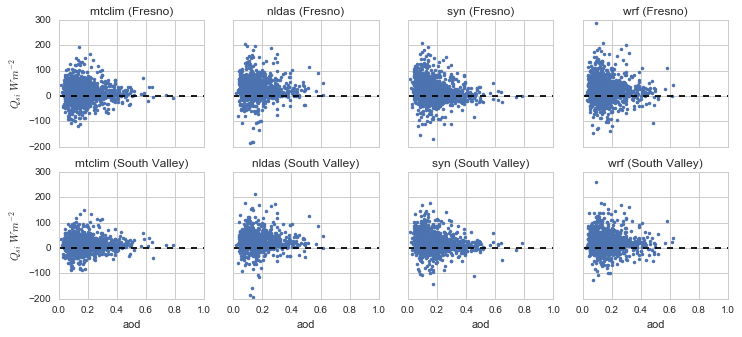

In [7]:
############################
## Bias w/ aod (Scatter )
grobs_diff_stations = xray.Dataset()
for pr in pr_names:
    grobs_diff_stations[pr] = (grobs[pr]-grobs.grobs)

f, axes = plt.subplots(2, num_products, figsize=(12,5),sharex='col',sharey='row')
for n,pr in enumerate(pr_names):
    ax = axes[0,n]
    
    ax.plot(grobs.aod,grobs_diff_stations[pr].loc[{'station':'FRESNO'}].values,'.')                  
    ax.plot(np.array([0,1]),np.array([0,0]),'k--')
    ax.set_title(pr+' (Fresno)')
    if n == 0:
        ax.set_ylabel('$Q_{si}$ $Wm^{-2}$')
    
    grobs_diff_group = kray.group_mean(grobs_diff_stations[pr].swap_dims({'station':'Grouping'}),'Grouping',grouping)
    grobs_diff_group = kray.combinevars(grobs_diff_group,grouping,new_dim_name='Grouping',combinevarname='bias')
    
    ax = axes[1,n]
    ax.plot(grobs.aod,grobs_diff_group.loc[{'Grouping':'south cv'}].values,'.')
    ax.plot(np.array([0,1]),np.array([0,0]),'k--')

    if n == 0:
        ax.set_ylabel('$Q_{si}$ $Wm^{-2}$')
    ax.set_title(pr+ ' (South Valley)')
    ax.set_xlabel('aod')


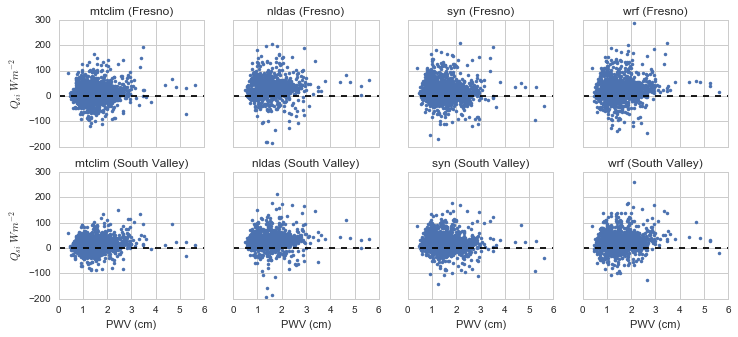

In [8]:
############################
## Bias w/ aod (Scatter )
grobs_diff_stations = xray.Dataset()
for pr in pr_names:
    grobs_diff_stations[pr] = (grobs[pr]-grobs.grobs)

f, axes = plt.subplots(2, num_products, figsize=(12,5),sharex='col',sharey='row')
for n,pr in enumerate(pr_names):
    ax = axes[0,n]
    
    ax.plot(grobs.wv,grobs_diff_stations[pr].loc[{'station':'FRESNO'}].values,'.')                  
    ax.plot(np.array([0,6]),np.array([0,0]),'k--')
    ax.set_title(pr+' (Fresno)')
    if n == 0:
        ax.set_ylabel('$Q_{si}$ $Wm^{-2}$')
    
    grobs_diff_group = kray.group_mean(grobs_diff_stations[pr].swap_dims({'station':'Grouping'}),'Grouping',grouping)
    grobs_diff_group = kray.combinevars(grobs_diff_group,grouping,new_dim_name='Grouping',combinevarname='bias')
    
    ax = axes[1,n]
    ax.plot(grobs.wv,grobs_diff_group.loc[{'Grouping':'south cv'}].values,'.')
    ax.plot(np.array([0,6]),np.array([0,0]),'k--')

    if n == 0:
        ax.set_ylabel('$Q_{si}$ $Wm^{-2}$')
    ax.set_title(pr+ ' (South Valley)')
    ax.set_xlabel('PWV (cm)')


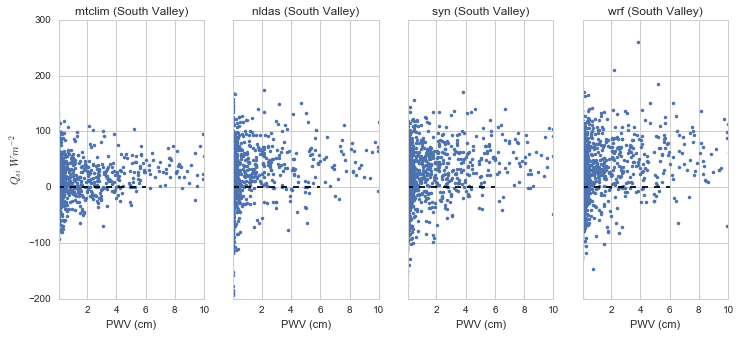

In [9]:
############################
## Bias w/ aod (Scatter )
grobs_diff_stations = xray.Dataset()
for pr in pr_names:
    grobs_diff_stations[pr] = (grobs[pr]-grobs.grobs)

f, axes = plt.subplots(1, num_products, figsize=(12,5),sharex='col',sharey='row')
for n,pr in enumerate(pr_names):        
    grobs_diff_group = kray.group_mean(grobs_diff_stations[pr].swap_dims({'station':'Grouping'}),
                                       'Grouping', grouping)
    grobs_diff_group = kray.combinevars(grobs_diff_group, grouping,
                                        new_dim_name='Grouping', combinevarname='bias')
    grobs_precip_group = kray.group_mean(grobs.precip.swap_dims({'station':'Grouping'}),
                                       'Grouping', grouping)
    grobs_precip_group = kray.combinevars(grobs_precip_group, grouping,
                                        new_dim_name='Grouping', combinevarname='bias')    
    ax = axes[n]
    ax.plot(grobs_precip_group.loc[{'Grouping': 'south cv'}],
            grobs_diff_group.loc[{'Grouping':'south cv'}].values,'.')
    ax.plot(np.array([0,6]),np.array([0,0]),'k--')

    if n == 0:
        ax.set_ylabel('$Q_{si}$ $Wm^{-2}$')
    ax.set_title(pr+ ' (South Valley)')
    ax.set_xlabel('PWV (cm)')
    ax.set_xlim(.05,10)


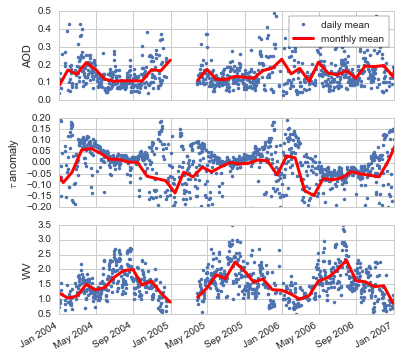

In [10]:
#### Time series
## AOD
f,axes = plt.subplots(3,1,sharex=True,figsize=(6,6))
axes[0].plot(grobs.time,grobs.aod.values,'.',label='daily mean')
axes[0].plot(grobs.aod.resample(freq='M',dim='time',how='mean').time,\
         grobs.aod.resample(freq='M',dim='time',how='mean').values,'r',linewidth=3,label='monthly mean')
axes[0].set_xlim([datetime(2004,1,1),datetime(2007,1,1)])
axes[0].set_ylabel('AOD')
axes[0].set_ylim([0.,.5])
leg = axes[0].legend(frameon=True)
leg.get_frame().set_edgecolor('k')

## Transmissivity
axes[1].plot(anom_day.time, anom_day.anom_mean.loc[{'Grouping':'south cv'}].values, '.')
axes[1].plot(anom_mon.time-pd.Timedelta(days=15),
             anom_mon['mean'].loc[{'Grouping':'south cv'}],
             'r',linewidth=3)
axes[1].set_xlim([datetime(2004,1,1),datetime(2007,1,1)])
axes[1].set_ylabel('$\\tau$ anomaly')
axes[1].set_ylim([-.2,.2])

## WV
axes[2].plot(grobs.time,grobs.wv.values,'.')
axes[2].plot(grobs.wv.resample(freq='M',dim='time',how='mean').time,\
         grobs.wv.resample(freq='M',dim='time',how='mean').values,'r',linewidth=3)
axes[2].set_xlim([datetime(2004,1,1),datetime(2007,1,1)])
axes[2].set_ylabel('WV')
axes[2].set_ylim([.5,3.5])

f.autofmt_xdate()

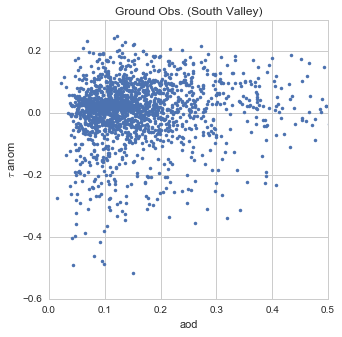

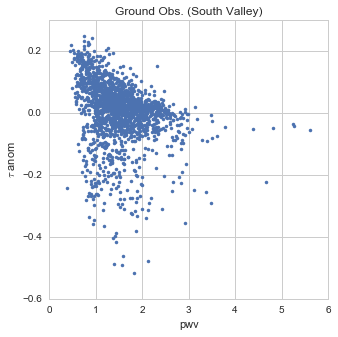

In [32]:
#### Correlations - AOD
# AOD
a = grobs.aod.values

## Correlation with transmissivity w/ products
f, ax = plt.subplots(1, 1, figsize=(5, 5))

# over group
ax.plot(a,anom_day.anom_mean.loc[{'Grouping':'south cv'}].values,'.')
ax.set_xlim([0,.5])
ax.set_xlabel('aod')
ax.set_ylabel('$\\tau$ anom')
ax.set_title(pr+ ' (South Valley)')
ax.set_title('Ground Obs. (South Valley)')

#### PWV and Tau anom

## Correlation with transmissivity w/ products
f, ax = plt.subplots(1, 1, figsize=(5, 5))

# over group
ax.plot(grobs.wv, anom_day.anom_mean.loc[{'Grouping':'south cv'}].values,'.')
ax.set_xlabel('pwv')
ax.set_ylabel('$\\tau$ anom')
ax.set_title(pr+ ' (South Valley)')
ax.set_title('Ground Obs. (South Valley)')

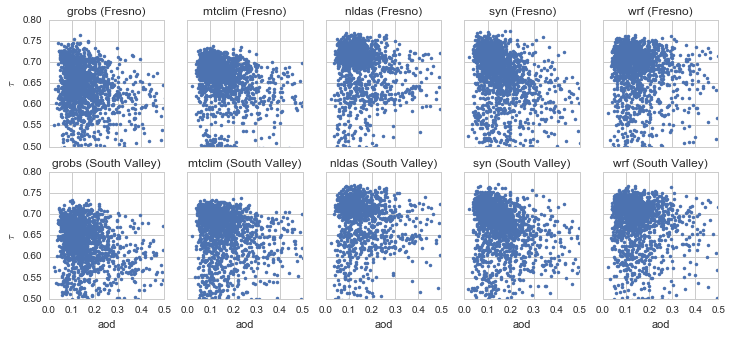

In [23]:
#### Correlations - AOD (ALL DATES)

# Correlation with transmissivity w/ products
f, axes = plt.subplots(2, num_products+1, figsize=(12,5),sharex='col',sharey='row')
for n,pr in enumerate(pr_for_plot):
    tau_pr = grobs[pr] / (np.sin(grobs.el*np.pi/180.) * 1365.)
        
    # @ Fresno
    ax = axes[0,n]
    ax.plot(a,tau_pr.loc[{'station':'FRESNO'}].values,'.')
    ax.set_title(pr+' (Fresno)')
    ax.set_ylim(.5, .8)
    if pr == 'SWdwn':
        ax.set_title('Ground Obs. (Fresno)')
    if n == 0:
        ax.set_ylabel('$\\tau$')
    
    tau_pr = kray.group_mean(tau_pr.swap_dims({'station':'Grouping'}),'Grouping',grouping)
    tau_pr = kray.combinevars(tau_pr,grouping,new_dim_name='Grouping',combinevarname='tau')

    # over group
    ax = axes[1,n]
    ax.plot(a,tau_pr.loc[{'Grouping':'south cv'}].values,'.')
    ax.set_ylim([.5,.8])
    ax.set_xlim([0,.5])
    ax.set_xlabel('aod')
    if n == 0:
        ax.set_ylabel('$\\tau$')
    ax.set_title(pr+ ' (South Valley)')
    if pr == 'SWdwn':
        ax.set_title('Ground Obs. (South Valley)')

In [39]:
print(grobs.wv.median(dim='time'))
print(grobs.aod.median(dim='time'))

<xarray.DataArray 'wv' ()>
array(1.435857)
<xarray.DataArray 'aod' ()>
array(0.1338865)
